# 🏨 Hotel Staff Size Prediction

**Objective:**  
Build a regression model to recommend an appropriate number of staff members for hotels based on property features. This notebook walks through the full data science workflow to solve this task using real hotel data.

---

### Notebook Workflow:
1. Load and inspect the dataset
2. Perform exploratory data analysis (EDA)
3. Select relevant predictive features
4. Preprocess the data (encoding, train/test split)
5. Train and evaluate a Ridge Regression model
6. Tune regularization and analyze model behavior

---

**Target variable:** `Staff`  
**Key predictors explored:** `m2`, `Max Number of Guests`, `Number of Rooms`, `Size of the Rooms`, `Maintenance Cost`

# Loading the required packages

In [1]:
# 📊 Notebook Configuration
%matplotlib inline

# 📦 Core Libraries
import numpy as np
import pandas as pd

# 📈 Visualization
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
sns.set_style('darkgrid')
sns.set(font_scale=1)

# 🔍 Feature Selection
from sklearn.feature_selection import f_regression, mutual_info_regression

# 🔄 Preprocessing & Model Selection
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler

# 🧠 Regression Models
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.kernel_ridge import KernelRidge
from sklearn.tree import DecisionTreeRegressor
from sklearn import tree

# 📏 Evaluation Metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy.stats import pearsonr

# 🖼️ Visualization Tools (for Decision Trees)
from graphviz import Source


## Loading the dataset and pre-processing the features
The dataset is loaded from the provided csv file and is presented in the following table.

In [2]:
# Loading the data from the CSV file
df = pd.read_csv('data\hotes_info.csv')
df = df.drop('Hotel Name', axis =1)
print(df.info())
df.head(6)

<>:2: SyntaxWarning: invalid escape sequence '\h'
<>:2: SyntaxWarning: invalid escape sequence '\h'
/var/folders/3b/p143t4hn1kzbzt8wz6ppzs9h0000gp/T/ipykernel_43447/233564251.py:2: SyntaxWarning: invalid escape sequence '\h'
  df = pd.read_csv('data\hotes_info.csv')
/var/folders/3b/p143t4hn1kzbzt8wz6ppzs9h0000gp/T/ipykernel_43447/233564251.py:2: SyntaxWarning: invalid escape sequence '\h'
  df = pd.read_csv('data\hotes_info.csv')


FileNotFoundError: [Errno 2] No such file or directory: 'data\\hotes_info.csv'

In [4]:
# Simplifying feature names 
columns = df.columns.values
columns[0] ="Area"
columns[2] ="Guests"
columns[3] ="Rnumber"
columns[4] ="Rsize"
columns[6] ="Cost"

df.columns = columns
df.head()

,Area,Age,Guests,Rnumber,Rsize,Staff,Cost
0,3511,2,192,96,29,2.9,241
1,1136,19,141,47,19,1.7,635
2,3347,2,534,267,10,5.9,441
3,3341,14,294,98,27,2.8,872
4,3975,18,327,109,29,2.6,698


In [5]:
# Looking for missing values in the dataset
for c in df.columns:
    no_missing = df[c].isnull().sum()
    if no_missing > 0:
        print(c)
        print(no_missing)
    else:
        print(c)
        print("No missing values")
        print(' ')

Area
No missing values
 
Age
No missing values
 
Guests
No missing values
 
Rnumber
No missing values
 
Rsize
No missing values
 
Staff
No missing values
 
Cost
No missing values
 


In [6]:
# getting mean and standard deviation of each feature
print('mean value for different features:\n',df.mean())
print('\nstandard deviation of different features:\n',df.std())

mean value for different features:
 Area       2935.887500
Age          10.718750
Guests      315.118750
Rnumber     128.443750
Rsize        20.193750
Staff         3.250625
Cost        540.043750
dtype: float64

standard deviation of different features:
 Area       1275.215409
Age           5.863405
Guests      196.701491
Rnumber      73.133181
Rsize         6.424694
Staff         1.484892
Cost        262.580933
dtype: float64


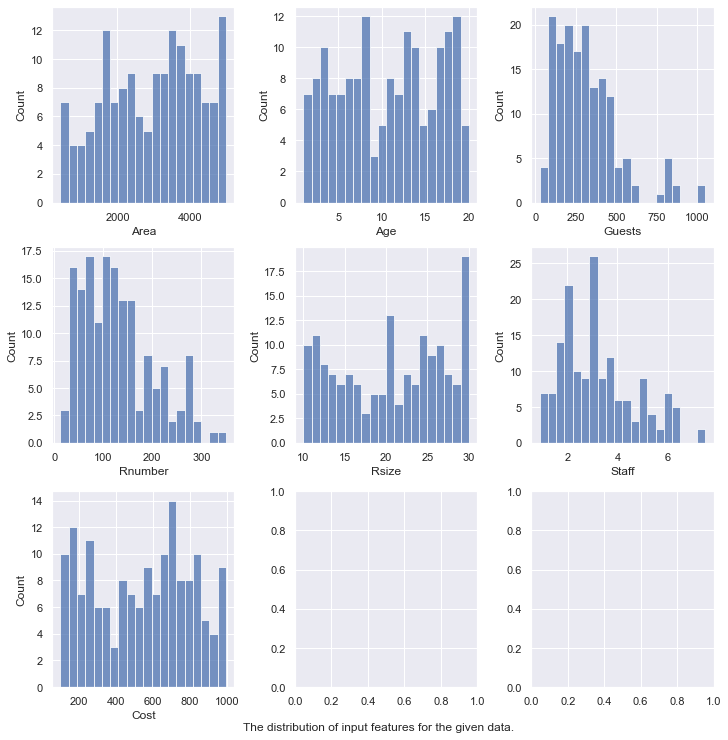

In [7]:
# Ploting the feature distributions
fig, ax = plt.subplots(3,3 , figsize=(10, 10), constrained_layout = True)
for cat, ax_i in zip(df.columns, ax.flatten()):
    sns.histplot(data = df, x= cat, kde=False, bins=20, ax=ax_i)  
txt="The distribution of input features for the given data."
fig.text(.52, -0.01, txt, ha='center');

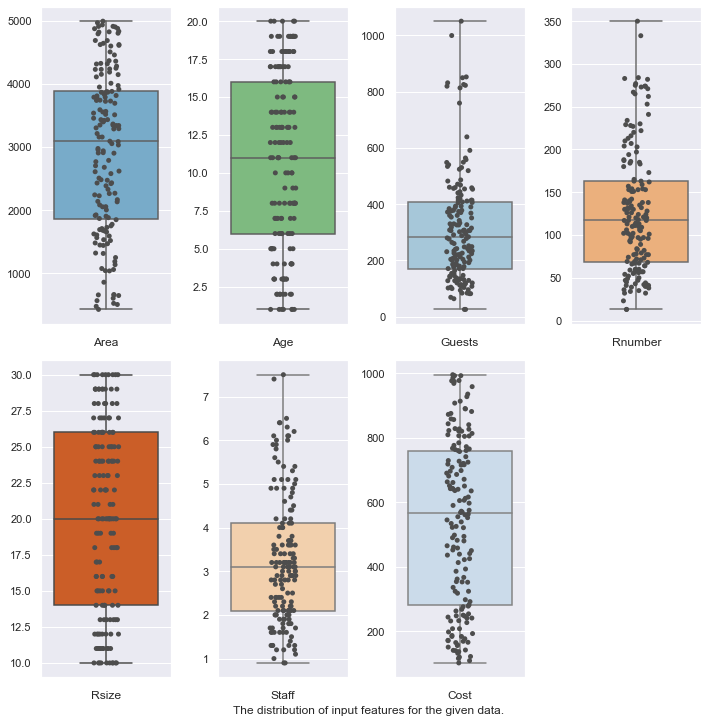

In [8]:
cmap = plt.get_cmap("tab20c")
colors = cmap([1,9,2,6,4,7,3])
# fig, ax = plt.subplots(2,2)
fig = plt.figure(figsize=(10,10))
for i,cat in enumerate(df.columns):
    fig_ind = 241+i
    ax1 = fig.add_subplot(fig_ind)
    x = sns.boxplot(y=cat, data=df, ax=ax1, whis=np.inf, color=colors[i])
    x = sns.stripplot(y=cat,data=df,color=".3")
    plt.xlabel(cat)
    plt.ylabel('')
fig.tight_layout()
txt="The distribution of input features for the given data."
fig.text(.52, 0.0, txt, ha='center');

Based on *maximum guests* and *Nr. of rooms* and the following figure, we can assume some of the data points on the corners of the input space as outliers.
However, I do not have enough data points (currently only 160 samples) to make that decision confidently.

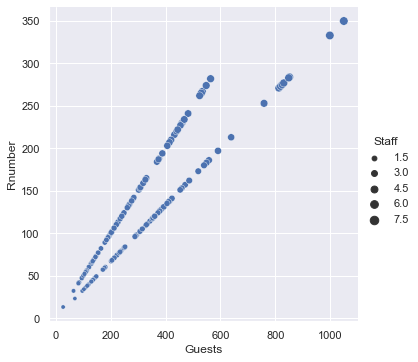

In [8]:
sns.relplot(x='Guests',y='Rnumber',size='Staff',data=df)

In [10]:
# ======== Normalizing feature values to have a zero average and standard deviation of one
x = df.drop('Staff', axis = 1).values
y = df.Staff.values.reshape(-1,1)
scaler = StandardScaler()
x = scaler.fit_transform(x)
y = scaler.fit_transform(y).ravel()
print('mean values of the features:\n',np.mean(x,axis = 0))
print('\nstandard deviations of the features:\n',np.std(x, axis =0))
x_norm = x.copy()
y_norm = y.copy()

mean values of the features:
 [ 1.33226763e-16  2.22044605e-17  1.22124533e-16  7.77156117e-17
 -2.60902411e-16 -1.60982339e-16]

standard deviations of the features:
 [1. 1. 1. 1. 1. 1.]


Text(0.52, -0.01, 'The distribution of input features after normalization of the data.')

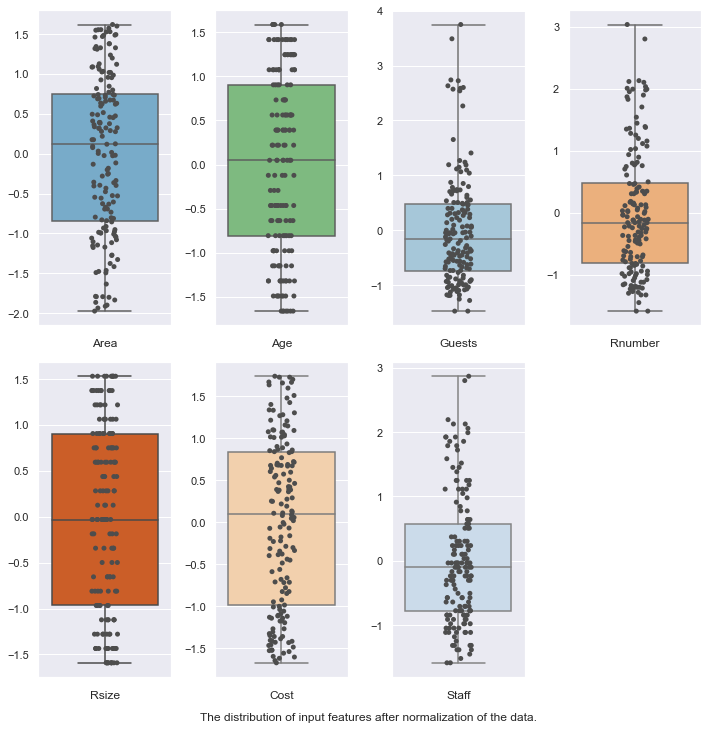

In [11]:
# feature distributions
x_col = df.columns.values
x_col = np.delete(x_col,5)
df_norm=pd.DataFrame(x_norm,columns=x_col)
df_norm.insert(len(x_col),'Staff',y,True)
cmap = plt.get_cmap("tab20c")
colors = cmap([1,9,2,6,4,7,3])
# fig, ax = plt.subplots(2,2)
fig = plt.figure(figsize=(10,10))
for i,cat in enumerate(df_norm.columns):
    fig_ind = 241+i
    ax1 = fig.add_subplot(fig_ind)
    sns.boxplot(y=cat, data=df_norm, ax=ax1, whis=np.inf, color=colors[i])
    sns.stripplot(y=cat,data=df_norm,color=".3")
    plt.xlabel(cat)
    plt.ylabel('')
fig.tight_layout()
txt="The distribution of input features after normalization of the data."
fig.text(.52, -0.01, txt, ha='center')

## Computing the feature relevances
Here I calculate the feature relvances using two different measures:
* f-score
* Mutual information

F-score looks for linear corelations between the features and the output values using cross-correlation.
Mutual information looks for nonlinear corelations by analysing the relationship between feature and the output.

Text(0.52, -0.03, 'Scoring the input features based on their correlation to the output values (Staff) using F-score and mutual information.')

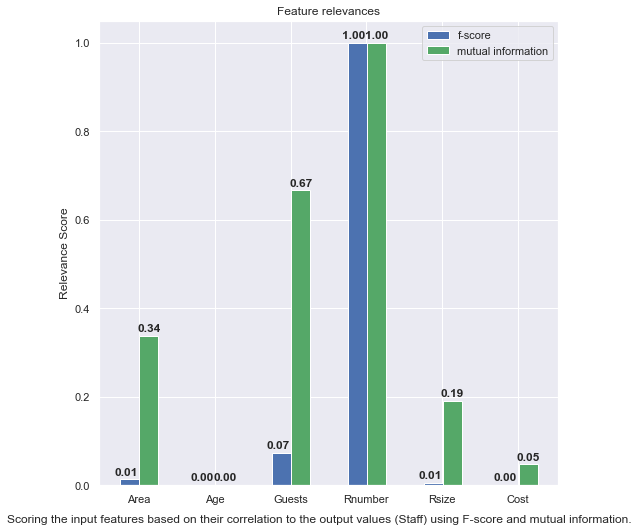

In [12]:
#  f-score and mutual information for feature relevances
# x_col = df.columns.values
# x_col = np.delete(x_col,5)
# x = df.drop('Staff', axis = 1).values
# y = df.Staff.values
f_features, _ = f_regression(x, y, center = True)
f_features /= np.max(f_features)

m_features = mutual_info_regression(x, y, n_neighbors = 3)
# m_features = mutual_info_regression(x, y, n_neighbors = 5)
m_features /= np.max(m_features)

fig, ax = plt.subplots(figsize = (7,7), constrained_layout = True)
x_feat = np.arange(len(df.columns)-1)
ax.bar(x_feat + 0.00, f_features, color = 'b', width = 0.25, label='f-score')
for i, v in zip(x_feat, f_features):
    ax.text(i-0.2, v+0.01, '{:.2f}'.format(v), fontweight='bold')
ax.bar(x_feat + 0.25, m_features, color = 'g', width = 0.25, label = 'mutual information')
for i, v in zip(x_feat, m_features):
    ax.text(i+0.1, v+0.01, '{:.2f}'.format(v), fontweight='bold')
ax.set_xticks(x_feat + 0.12)
ax.set_ylabel('Relevance Score')
ax.set_xticklabels(x_col.tolist())
ax.legend()
ax.set_title('Feature relevances')
txt="Scoring the input features based on their correlation to the output values (Staff) using F-score and mutual information."
fig.text(.52, -0.03, txt, ha='center')

Based on the above figure, the feature *Number of rooms* has the highest linear correlation to the *staff size*, and the rest of the features are relatively neglectable.
On the other hand, for a non-linear regression model, there are 4 features (*Nr. of rooms*, *Nr. of guests*, *hotel's area*, and *Room sizes*) that are recognized as the most important information to predict the *staff* size.

As an interesting observation, the following figures show a linear relationship between the *Staff size* and *Number of rooms* and a high correlation between *Staff size* and *Maximum Guests*, which is why we observed a relatively high score for those features in the F-score ouput.

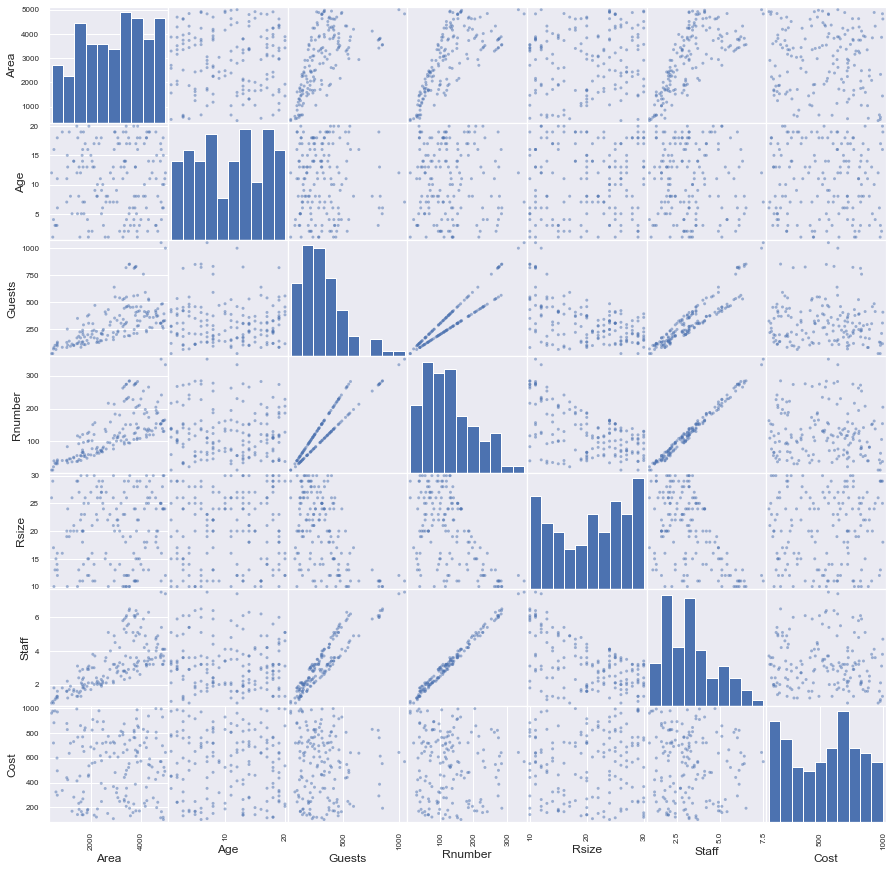

In [16]:
# %% scater matrix
pd.plotting.scatter_matrix(df, figsize = (15,15));

Text(0.5, 0, 'Staff')

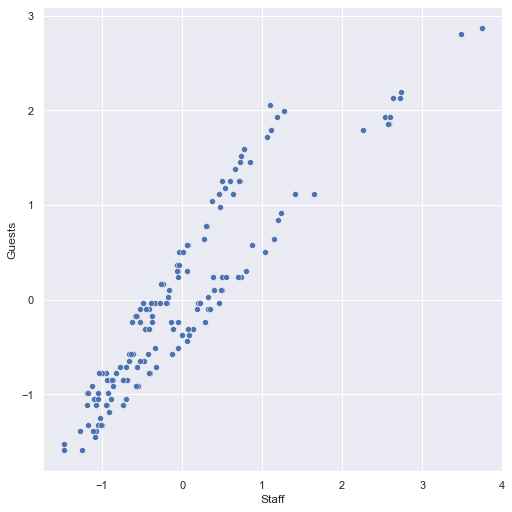

In [18]:
fig, ax = plt.subplots(figsize = (7,7), constrained_layout = True)
sns.scatterplot(x=x_norm[:,2], y=y_norm)
ax.set_ylabel('Guests')
ax.set_xlabel('Staff')

The correlation matrix shows a strong correlation between *Nr. Guests*, *Nr. Rooms*, and *Area* as well as their correlations to the output *Staff size*. This information coincides with the feature relevance plot.

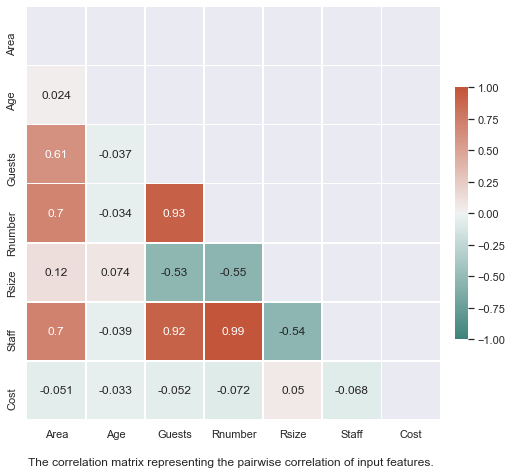

In [14]:
# feature correlations
correlation = df.corr()
mask = np.zeros_like(correlation, dtype=bool)
mask[np.triu_indices_from(mask)] = True
# ploting the feature relevance matrix
fig, ax = plt.subplots(figsize=(7, 7), constrained_layout = True)
cmap = sns.diverging_palette(180, 20, as_cmap=True)
sns.heatmap(correlation, mask=mask, cmap=cmap, vmax=1, vmin =-1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)
txt="The correlation matrix representing the pairwise correlation of input features."
fig.text(.45, 0.001, txt, ha='center');

## Training a linear regression model
At the begining, I train a linear regression model to predic the *staff size* by only using the values of *Nr. of rooms*.
First, I define some practical functions, and then I train my models by using them.

In [42]:
# This function trains a regression model and evaluates it based on the prediction error, R2 score, and the requested Pearson correlation coefficient
def train_eval(regr, verbose = True):    
    # Train the model using the training sets
    regr.fit(X_train, y_train)
    # The coefficients
    p_corrs, r2s, MSEs=[],[],[]
            
    if verbose:
        if hasattr(regr, 'coef_'):
            print("Model information:")            
            print('{:>40}{}'.format('Regression model: ',regr))
            print('{:>40}{}'.format('Coefficients: ',regr.coef_))
            print('{:>40}'.format('Offset parameter: '), regr.intercept_)
        
        print("Evaluation Metrics:")        
    for x,y,label in zip([X_train,X_test],[y_train,y_test],['train','test']):
        # The mean squared error
        p_corrs.append(pearsonr(regr.predict(x), y)[0])
        r2s.append(regr.score(x, y))
        MSEs.append(mean_squared_error(regr.predict(x), y))
        # The mean squared error
        if verbose:
            print("{:>40} {}: {:.3f}".format("Mean squared error of",label,MSEs[-1]))
            # Explained variance score: 1 is perfect prediction
            print("{:>40} {}: {:.3f}".format('coefficient of determination R^2 of',label,r2s[-1]))
            print("{:>40} {}: {:.3f}".format('Pearson correlation coefficient of: ',label,p_corrs[-1]))
    return p_corrs, r2s, MSEs

# --------------------------------
# This function performs a training loop over a specific range of the hyper-parameter and evaluate the models results
def regul_eval(regr,param_range):
    coefs, p_corrs, errors, MSEs, r2s = ([] for i in range(5))
    for a in param_range:
        if type(regr) == DecisionTreeRegressor:
            regr.set_params(max_depth=a)
        else:
            regr.set_params(alpha=a)
        regr.fit(X_train, y_train)
        if hasattr(regr,'coef_'):
            coefs.append(regr.coef_)
        elif type(regr) == DecisionTreeRegressor:
            coefs.append(regr.feature_importances_)

        p_corr, r2, MSE = train_eval(regr,verbose=False)
        # _, corr_ts, _, r2_ts = train_eval(regr,verbose=False)
        p_corrs.append(p_corr)
        r2s.append(r2)
        MSEs.append(MSE)

    plt.figure(figsize=(20, 6),constrained_layout=False)
    listy = ['Model coefficients', 'Prediction error', 'Pearson Correlation Coefficient', 'R2 score']
    listx = [coefs, MSEs, p_corrs, r2s]
    for i_p, label_y, val_x in zip(range(4), listy, listx):
        plt.subplot(221 + i_p)
        ax = plt.gca()
        if val_x:
            ax.plot(param_range, val_x)
        if label_y == 'Model coefficients':
            ax.legend(labels=['feature {}'.format(i) for i in range(X_train.shape[1])])
        else:
            ax.legend(labels=['train', 'test'])
        if type(regr) != DecisionTreeRegressor:
            ax.set_xscale('log')
            plt.xlabel('alpha')
        else:
            plt.xlabel('Tree depth')
        plt.ylabel(label_y)
        plt.axis('tight')
    txt="Effect of the regularization parameter on the performance and coefficients of the regression model."
    fig.text(.52, 0.021, txt, ha='center')

# --------------------------
# This function computes the variance and bias of the model
# while training it on different training sets and compares
# the variation of its prediction on a test set
def bias_variance(regr,alphas):
    bias, variance = [], []
    for a in alphas:
        if type(regr) == DecisionTreeRegressor:
            regr.set_params(max_depth=a)
        else:
            regr.set_params(alpha=a)
        y_pred = []
        for i_sp in range(50):
            rnd = np.random.randint(1,10000)
            X_train2, _, y_train2, _ = train_test_split(X_train, y_train, test_size=0.40, random_state=rnd)
            regr.fit(X_train2, y_train2)
            y_pred.append(regr.predict(X_test))
        bias.append(mean_squared_error(np.mean(y_pred,axis=0),y_test))
        variance.append(np.mean(np.std(y_pred,axis=0)))

    plt.figure(figsize=(20, 6))
    for label, valx, i_p in zip(['bias', 'variance'],[bias, variance], range(2)):
        plt.subplot(121 + i_p)
        ax = plt.gca()
        ax.plot(alphas, valx)
        if type(regr) != DecisionTreeRegressor:
            ax.set_xscale('log')
            plt.xlabel('alpha')
        else:
            plt.xlabel('Tree depth')
        plt.ylabel('Model {}'.format(label))
        plt.title('Model {} as a function of the regularization'.format(label))
        plt.axis('tight')  

In [40]:
# training the linear regression model using only feature 3, Nr. of rooms
x = x_norm[:,3].copy().reshape(-1,1)
X_train, X_test, y_train, y_test = train_test_split(x, y_norm, test_size=0.40, random_state=42)
regr_lin = LinearRegression(fit_intercept = True, normalize = False)
regr_lin.fit(X_train, y_train)
mean_squared_error(regr_lin.predict(X_test), y_test)
# mean_absolute_error(regr_lin.predict(X_test), y_test)
_,_,_=train_eval(regr_lin)

Model information:
                      Regression model: LinearRegression()
                          Coefficients: [0.99532517]
                      Offset parameter:  0.019143816958019692
Evaluation Metrics:
                   Mean squared error of train: 0.013
     coefficient of determination R^2 of train: 0.987
    Pearson correlation coefficient of:  train: 0.993
                   Mean squared error of test: 0.014
     coefficient of determination R^2 of test: 0.986
    Pearson correlation coefficient of:  test: 0.994


The linear model has a small prediction error and high $R^2$ and Pearson correlation values, which shows that only using one feature (*Nr. of Rooms*) is effective for predicting the required *staff* size.

Personally, I prefer to use the mean square error and $R^2$ measures instead of the Pearson correlation coefficient for the evaluation of regression models.
In fact, the Pearson metric shows the linear relationship between the two variables. 
However, a regression model's output can be correlated to the real output while still having a high prediction error.
In an exceptional case (simple linear regression problem), R2 can be equal to the Pearson coefficient.

## Linear regression with regularization
In this part, I train and evaluate a Ridge regression model to apply the regularization parameter as requested.
However, for the sake of application and the experiments, I use all the data features in the following experiments. 

The reason behind using regularization is to prevent the model from overfitting to the training data and have better generalization on the test data.
In other words, the right choice of regularization should improve the variance of the model by enduring some amount of training error.
Furthermore, this hyper-parameter generally works toward increasing the model's bias. However, the amount and extent of that depend on the model's and the given task's complexity.

Despite the above, I believe that our previous model can already serve the purpose of predicting the *staff* sizes in a real scenario.

Model information:
                      Regression model: Ridge(alpha=10)
                          Coefficients: [ 0.22052321 -0.00525318  0.22027585  0.5020015  -0.14691227 -0.0046115 ]
                      Offset parameter:  0.013790034996518825
Evaluation Metrics:
                   Mean squared error of train: 0.026
     coefficient of determination R^2 of train: 0.974
    Pearson correlation coefficient of:  train: 0.988
                   Mean squared error of test: 0.028
     coefficient of determination R^2 of test: 0.972
    Pearson correlation coefficient of:  test: 0.987


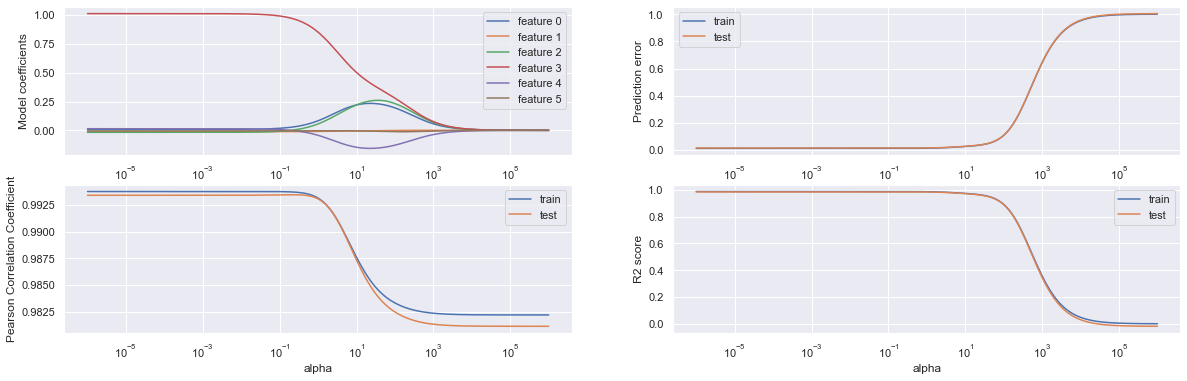

In [43]:
x = x_norm.copy()
X_train, X_test, y_train, y_test = train_test_split(x, y_norm, test_size=0.40, random_state=42)

regr_ridge = Ridge(alpha=10)
train_eval(regr_ridge)

alphas = np.logspace(-6, 6, 200)

regul_eval(regr_ridge,alphas)

According to the above figures, the ridge regression model works similar to the linear model when the regularization parameter ($\alpha$) is near zero.
However, increasing this parameter leads to the decrease in the dominant feature's role (*Nr. of Rooms*) and brings contributions from other features to minimize the overall $l_2$-norm of all coefficients together. For instance, the model still has an acceptable MSE and $R^2$ values when we have $\alpha=10$.
However, most of the features are used at this point, and the model starts to lose its accuracy when we increase $\alpha$ further.
It is clear that when $\alpha$ is significantly large, the model forces all the coefficients to become near zero, and almost no prediction happens after this point.

To properly examine the effect of the regularization parameter on the bias and variation of the model, I designed the following experiment setup.
These qualities are related to the model's performance when its parameters are trained using different batches of the training set.
Therefore, I perform multiple training sessions on different parts of the training data. Then the bias and variation of the model are examined based on the predicted output of the model and plotted against the corresponding regularization value. 

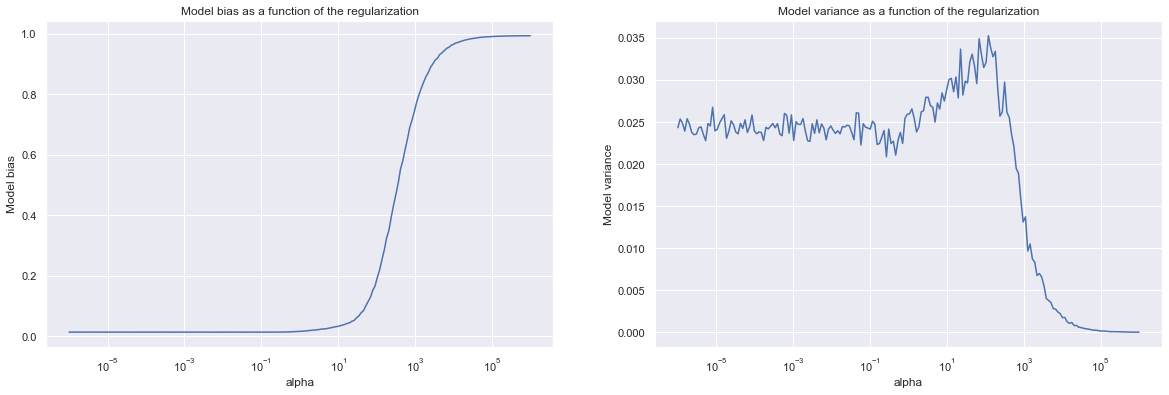

In [47]:
# computing the model bias and variance by performing several
# trainings on different parts of the data and studying 
# its effect on the prediction of the test data
regr = Ridge(fit_intercept=False)
bias_variance(regr,alphas)

As we see in the above figures, by increasing the regularization weight, the regression model's bias increases monotonically, as expected.
This behavior corresponds with the model's failure to fit any training data when $\alpha$ is relatively large.
We observe a slight increase in the model's variance on the right figure, while a considerable decrease of this value when $\alpha$ becomes large.
This behavior happens precisely in accordance with the change of coefficient values. Around $\alpha=10$, other parameters start to grow, which increases the model's variance by improving its degree of complexity and its ability to fit various training data batches. 
Nevertheless, for the larger values of $\alpha$ (close to $10^3$), all the parameters are forced to become close to zero, and the model loses its ability to fit the variations in the data.

## Non-linear regression models
In order to also study the behavior of a non-linear regression model respecting the above concerns, I apply the following two different regression methods:
* Kernel-based ridge regression
* Decision tree regression

### Kernel-based ridge regression
The kernel-based ridge model is the non-linear extension of the ridge regression method, which is applied in the following by using an RBF kernel.
The following implementation shows that the kernel model managed to obtain a $0$ prediction error on the training set. It means the model has used other features besides *Nr. of Rooms* in its model, which were also indicated in the mutual information ranking (e.g., features 0,2).
However, the kernel model has a more significant prediction error on the test set than the regular ridge regression due to its overfitting to the training data.

In [48]:
# implementation of kernel ridge regression model
alpha = 0
gamma = .08
regr_ridge_kernel = KernelRidge(alpha=alpha, gamma=gamma, kernel='rbf')  
_,_,_=train_eval(regr_ridge_kernel)

Evaluation Metrics:
                   Mean squared error of train: 0.000
     coefficient of determination R^2 of train: 1.000
    Pearson correlation coefficient of:  train: 1.000
                   Mean squared error of test: 0.140
     coefficient of determination R^2 of test: 0.858
    Pearson correlation coefficient of:  test: 0.930


Performing a regularization on the kernel regression model shows that by increasing $\alpha$, we obtain a better prediction on the test set. This behavior is due to the increase of the generalization ability of the model. Besides that observation, the prediction error and $R^2$ score follow the same trend as in the regular model when we use large regularization weights.

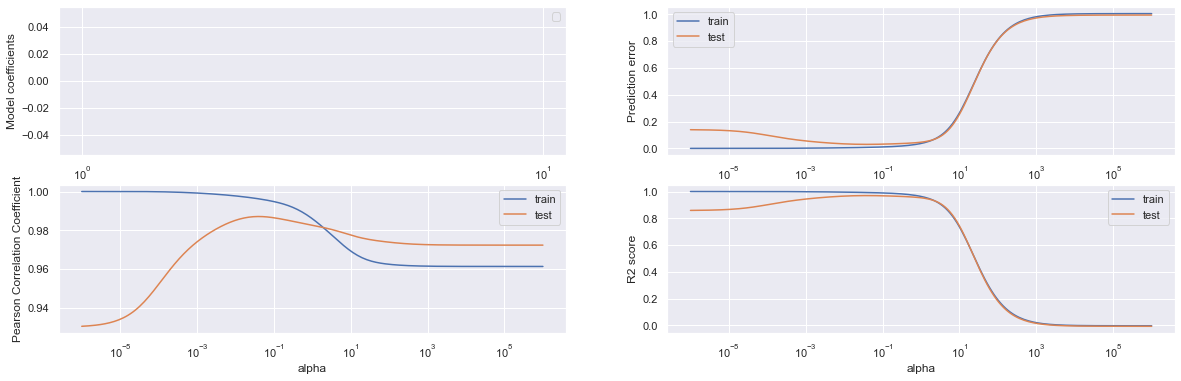

In [23]:
# finding effect of regularization on the performance of the kernel-ridge model
alphas = np.logspace(-6, 6, 200)

regul_eval(regr_ridge_kernel,alphas)

Observing the effect of regularization on the model bias and variance reveals an almost monotonic increase of the bias and the decrease of variance. Apparently, the point $\alpha=0.1$ is where the model has its beset balance regarding the bias and its flexibility to the training data variations.

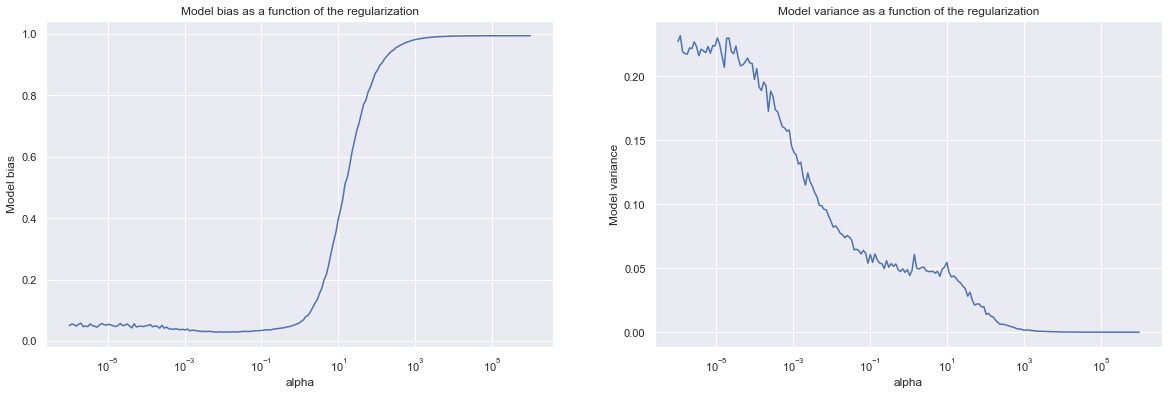

In [24]:
bias_variance(regr_ridge_kernel,alphas)

### Decision tree regression
As another non-linear regression model, I implement the Decision tree regression method. This model is a specifically popular technique for predicting non-linear behaviors when we want to preserve the interpretability of the prediction model and its decision-making process. For the DT model, the hyperparameter that we can use for regularization is the tree's maximum depth.
This parameter indirectly limits the number of used input features in the decision-making process of the model.

In [49]:
# Training and evaluating a decision tree regression model
regr_dt = DecisionTreeRegressor(max_depth=3)
regr_dt.fit(X_train, y_train)
_,_,_ = train_eval(regr_dt)

Evaluation Metrics:
                   Mean squared error of train: 0.020
     coefficient of determination R^2 of train: 0.980
    Pearson correlation coefficient of:  train: 0.990
                   Mean squared error of test: 0.095
     coefficient of determination R^2 of test: 0.904
    Pearson correlation coefficient of:  test: 0.959


By visualizing the DT, we see that the model has picked the *Nr. of rooms* as the most relevant feature for predicting the *Staff* value.
After this feature, other essential features, as also it was indicated in the mutual information figure, are used (*Area*, *Room Size*, and *Guests*).
This observation coincides with our previous finding of the non-linear role of the above additional features in the prediction task.

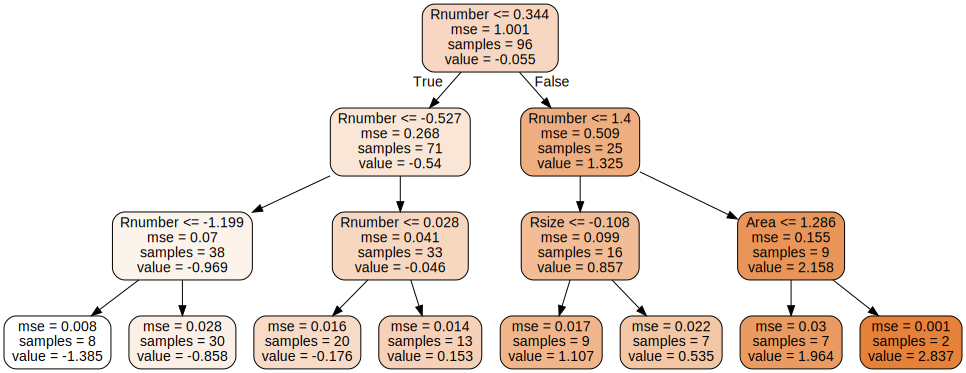

In [50]:
# visualization of the tree
dot_data = tree.export_graphviz(regr_dt, out_file=None,
                                    feature_names= x_col,
                                    # class_names= le.classes_,
                                    filled=True, rounded=True)
graph = Source(dot_data, format="png")
graph

Regarding the effect of model regularization on its performance, we observe that the DT always chooses the 3rd feature as the most important one. This is a key difference between this regression model and the previous ones. In other words, the regression model still has one feature to use even under a harsh regularization. As the immediate benefit of this characteristic, we observe that MSE and $R^2$ score were not damaged the way they were in other models. Therefore, this model shows a better generalization over the test set (smaller prediction error) compared to the ridge regression.

Despite the above strength, a decision tree cannot outperform the simple linear regression model when the prediction task can be linearly solved by using only a single feature from the data!

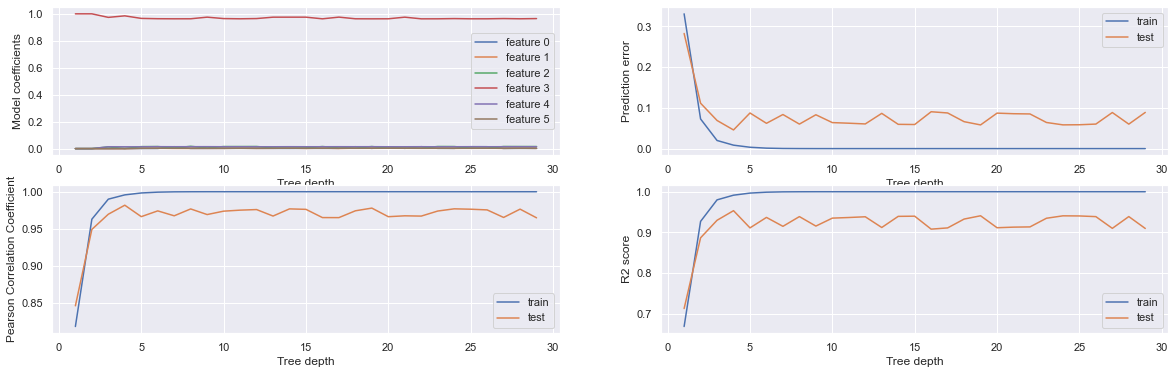

In [27]:
depths = np.arange(1,30)
regul_eval(regr_dt,depths)

According to the following figures, the decision tree has a considerably low bias for the whole range of its hyperparameter (maximum depth).
Even in the worst case, its bias doesn't go above $0.2$ compared to the maximum possible bias of $1$.
In other words, the model shows robustness in terms of its bias even when we enforce high regularization on it. This observation is due to the fact that DT makes no assumption about its target function.

On the other hand, the model shows a relatively high variance compared to the other two regression methods. This observation is because of the high sensitivity of decision trees to the variance in the training data.

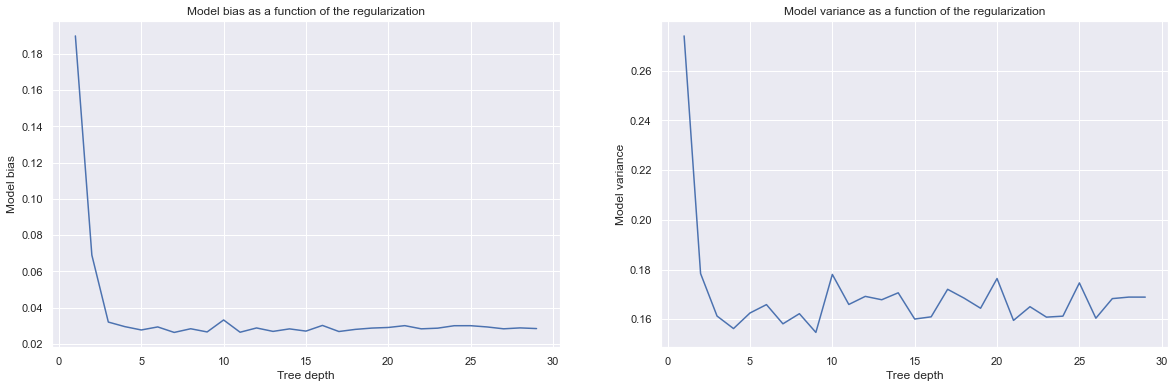

In [28]:
bias_variance(regr_dt,depths)